<a href="https://colab.research.google.com/github/rbdus0715/Machine-Learning/blob/main/study/torch/4.rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[데이터](https://www.kaggle.com/competitions/netflix-stock-prediction/data)

### **1. 데이터 다루기**

In [37]:
import pandas as pd

data = pd.read_csv("train.csv")
data.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [38]:
import numpy as np
from torch.utils.data.dataset import Dataset

class Netflix(Dataset):
    def __init__(self):
        self.csv = pd.read_csv("train.csv")
        self.data = self.csv.iloc[:, 1:4].values
        self.data = self.data / np.max(self.data) # 0~1 사이로 정규화

        self.label = data['Close'].values
        self.label = self.label / np.max(self.label)

    def __len__(self):
        return len(self.data) - 30

    def __getitem__(self,i):
        data = self.data[i:i+30]
        label = self.label[i+30]
        return data, label

### **2. 모델**

In [39]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        # [시계열, 배치, 데이터] or [배치, 시계열, 데이터]
        # input_size=3: 피쳐의 개수가 3개
        # hidden_size=8: MLP 이후에 차원이 변형되는 것과 같이 3개의 features가 8차원으로 벡터화됨
        # num_layers=5: RNN층 몇 개를 쌓을것인지
        self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)
        # 30일치 데이터 x 은닉상태 8 => 240 (평탄화)
        self.fc1 = nn.Linear(in_features=240, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x, h0):
        x, hn = self.rnn(x, h0) # h0는 초기 은닉 상태

        x = torch.reshape(x, (x.shape[0], -1))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        # [[0], [1], [2]] => [0, 1, 2]
        x = torch.flatten(x)
        return x

### **3. 학습**

In [40]:
import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNN().to(device)
dataset = Netflix()
loader = DataLoader(dataset, batch_size=32)
optim = Adam(params=model.parameters(), lr=0.0001)

In [41]:
for epoch in range(200):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        optim.zero_grad()
        h0 = torch.zeros(5, data.shape[0], 8).to(device)

        pred = model(data.type(torch.FloatTensor).to(device), h0)

        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
        loss.backward()
        optim.step()

        iterator.set_description(f"epoch{epoch} loss{loss.item()}")

torch.save(model.state_dict(), "./rnn.pth")

epoch199 loss0.0006984163774177432: 100%|██████████| 30/30 [00:02<00:00, 10.55it/s]


### **4. 테스트**

In [43]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1)
preds = []
total_loss = 0

with torch.no_grad():
    model.load_state_dict(torch.load("rnn.pth", map_location=device))

    for data, label in loader:
        h0 = torch.zeros(5, data.shape[0], 8).to(device)
        pred = model(data.type(torch.FloatTensor).to(device), h0)
        preds.append(pred.item())

        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
        total_loss += loss/len(loader)

total_loss.item()

0.0018525276100263

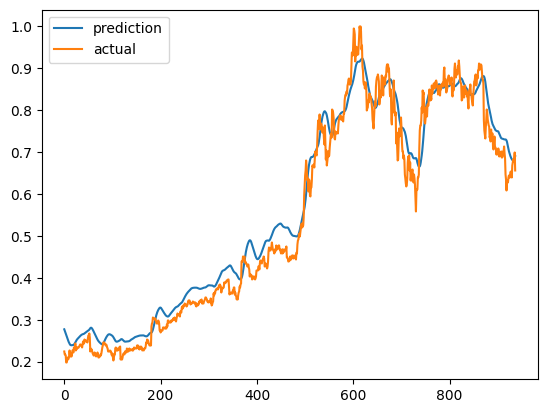

In [44]:
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()